In [1]:
# This file should be made to view and aggregate results
#%%
import itertools
import pprint
import argparse
import sys
import os
import pylab as plt
import pandas as pd
import sys
import numpy as np
import hashlib 
import pickle
import json
import glob
import copy


RUN_LIST = [0,1,2,3,4]

In [2]:
# ==========================================
# Utils
# ==========================================
def get_dataframe_exp_list(exp_list,  col_list=None, savedir_base=""):
    meta_list = []
    for exp_dict in exp_list:
        exp_meta = get_exp_meta(exp_dict, savedir_base)
        meta_dict = copy.deepcopy(flatten_dict(exp_dict))
        meta_dict["exp_id"] = exp_meta["exp_id"]
        # meta_dict["savedir"] = exp_meta["savedir"]
        # meta_dict["command"] = exp_meta["command"]
        if meta_dict == {}:
            continue
        meta_list += [meta_dict]
    df =  pd.DataFrame(meta_list).set_index("exp_id")
    if col_list:
        df = df[[c for c in col_list if c in df.columns]]
    return df


def get_dataframe_score_list(exp_list, col_list=None, savedir_base=None):
    score_list_list = []
    # aggregate results
    for exp_dict in exp_list:
        result_dict = {}
        exp_meta = get_exp_meta(exp_dict, savedir_base=savedir_base)
        result_dict["exp_id"] = exp_meta["exp_id"]
        if not os.path.exists(exp_meta["savedir"]+"/score_list.pkl"):
            score_list_list += [result_dict]
            continue
        score_list_fname = os.path.join(exp_meta["savedir"], "score_list.pkl")
        if os.path.exists(score_list_fname):
            score_list = load_pkl(score_list_fname)
            score_df = pd.DataFrame(score_list)
            if len(score_list):
                score_dict_last = score_list[-1]
                for k, v in score_dict_last.items():
                    if "float" not  in str(score_df[k].dtype):
                        result_dict[k] = v
                    else:
                        result_dict[k] = "%.3f (%.3f-%.3f)" % (v, score_df[k].min(), score_df[k].max())

        score_list_list += [result_dict]
    df = pd.DataFrame(score_list_list).set_index("exp_id")
    # join with exp_dict df
    df_exp_list = get_dataframe_exp_list(exp_list, col_list=col_list)
    df = join_df_list([df, df_exp_list])
    # filter columns
    if col_list:
        df = df[[c for c in col_list if c in df.columns]]
    return df


def get_plot(
        exp_groups,
        savedir_base,
        col_list,
        col_label=None,
        col_list_title=None
    ):
    nrows = len(col_list)
    ncols = len(exp_groups)
    fig, axs = plt.subplots(nrows=max(1,nrows), 
                            ncols=max(1, ncols), 
                            figsize=(ncols*6, nrows*6))
    if axs.ndim == 1:
        axs = axs[:, None]
    for i, col in enumerate(col_list):
        for j, exp_config_name in enumerate(exp_groups):
            exp_list = cartesian_exp_config(cfg.EXP_CONFIG[exp_config_name])
            for exp_dict in exp_list:
                exp_meta = get_exp_meta(exp_dict, savedir_base=savedir_base)
                path = exp_meta["savedir"] + "/score_list.pkl"
                if os.path.exists(path):
                    score_list = load_pkl(path)
                    score_df = pd.DataFrame(score_list)
                    axs[i,j].plot(score_df["epoch"], score_df[col],
                                        label=exp_dict[col_label])
            # prepare figure
            axs[i,j].set_ylabel(col)
            axs[i,j].set_xlabel("epochs")
            if col_list_title is not None:
                axs[i,j].set_title("_".join([exp_dict[c] for c in col_list_title]))
            axs[i,j].legend( loc='upper right', bbox_to_anchor=(0.5, -0.05))  
    return fig


def view_images(exp_list, savedir_base, image_dir, n_images=100):
    for exp_dict in exp_list:
        exp_meta = get_exp_meta(exp_dict, savedir_base=savedir_base)
        pprint.pprint(exp_dict)
        meta_dict = copy.deepcopy(flatten_dict(exp_dict))

        meta_dict["exp_id"] = exp_meta["exp_id"]
        savedir = exp_meta["savedir"] + "/" + image_dir
        
        show_folder(savedir, n_images=n_images)
    

# ===========================================
# helpers
def join_df_list(df_list):
    result_df = df_list[0]
    for i in range(1, len(df_list)):
        result_df = result_df.join(df_list[i], how="outer", lsuffix='_%d'%i, rsuffix='')
    return result_df


def show_folder(savedir, n_images=100):
    image_list = glob.glob(savedir + "*.jpg") + glob.glob(savedir + "*.png")
    image_list.sort(key=os.path.getmtime)
    image_list = image_list[::-1]
    if len(image_list) == 0:
        print("\nno images found at %s" % savedir)
        return
    for i, fname in enumerate(image_list):
        if i < n_images:
            # print(i)
            plt.figure(figsize=(11,4))
            plt.imshow(plt.imread(fname))
            plt.title(extract_fname(fname))
            # if os.path.exists(fname.replace(".jpg",".json")):
            #     pprint(load_json(fname.replace(".jpg",".json")))
            meta_name = fname.split(".")[0] + ".pkl"
            if os.path.exists(meta_name):
                plt.title(load_pkl(meta_name))
            plt.tight_layout()
            plt.show()


def get_plot_coupled(exp_list, row_list, savedir_base, opt2plot, metric2plot, title_list=None,
                     legend_list=None, avg_runs=0, e_epoch=None, y_limits = None):
    nrows = len(row_list)
    # ncols = len(exp_configs)
    ncols = 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                            figsize=(ncols*6, nrows*6))
    for i, row in enumerate(row_list):
        # exp_list = cartesian_exp_config(EXP_GROUPS[exp_config_name])
        for exp_dict in exp_list:
            exp_meta = get_exp_meta(exp_dict, savedir_base=savedir_base)
            path = exp_meta["savedir"] + "/score_list.pkl"
            if os.path.exists(path) and os.path.exists(exp_meta["savedir"] + "/exp_dict.json"):                
                if exp_dict.get("runs") is None or not avg_runs:
                    mean_list = load_pkl(path)
                    mean_df = pd.DataFrame(mean_list)
                    std_df = None
                elif exp_dict.get("runs") == 0:
                    # score_list = load_pkl(path)
                    mean_df, std_df = get_score_list_across_runs(exp_dict, savedir_base=savedir_base)
                else:
                    continue
                opt_name = "_".join([str(exp_dict.get(k)['name']) for k in legend_list])
                if e_epoch:
                    axs[i].plot(mean_df["epoch"][:e_epoch], mean_df[row][:e_epoch],
                                label = opt2plot[opt_name][0],                                              
                                color = opt2plot[opt_name][1],
                                marker = opt2plot[opt_name][2],
                                ms = 8,
                                markevery = 15
                               ) 
                else:
                    axs[i].plot(mean_df["epoch"], mean_df[row],
                                 label = opt2plot[opt_name][0],
                                 color = opt2plot[opt_name][1],
                                 marker = opt2plot[opt_name][2],
                                ms = 8,
                                markevery = 15
                               ) 
                if std_df is not None:
                    # do shading
                    offset = 0
                    # print(mean_df[row][offset:] - std_df[row][offset:])
                    # adsd
                    axs[i].fill_between(mean_df["epoch"][offset:], 
                            mean_df[row][offset:] - std_df[row][offset:],
                            mean_df[row][offset:] + std_df[row][offset:], 
                            color = opt2plot[opt_name][1],
                            alpha=0.1)
        # prepare figure
        if row == "train_loss" or row == "step_size":   
            axs[i].set_yscale("log")
            axs[i].set_ylabel(metric2plot[row] + " (log)")
        else:
            axs[i].set_ylabel(metric2plot[row])
        if row == "val_acc" :
            axs[i].set_ylim(y_limits[0], y_limits[1])
        axs[i].set_xlabel("epochs")
        axs[i].set_title("_".join([str(exp_dict.get(k)) for k in title_list]))
        axs[i].grid(True)
        plt.legend(loc= 'center', frameon = True, bbox_to_anchor=(0,-0.2), fancybox=True, 
                   ncol = 4, fontsize = 15)
    return fig

def get_score_list_across_runs(exp_dict, savedir_base):    
    exp_meta = get_exp_meta(exp_dict, savedir_base=savedir_base)
    score_list = load_pkl(exp_meta["savedir"] + "/score_list.pkl")
    keys = score_list[0].keys()
    result_dict = {}
    for k in keys:
        result_dict[k] = np.ones((exp_dict["max_epoch"], len(RUN_LIST)))*-1
    bad_keys = set()
    for r in RUN_LIST:
        exp_dict_new = copy.deepcopy(exp_dict)
        exp_dict_new["runs"]  = r
        exp_meta = get_exp_meta(exp_dict_new, savedir_base=savedir_base)
        score_list_new = load_pkl(exp_meta["savedir"] + "/score_list.pkl")
        df = pd.DataFrame(score_list_new)
        for k in keys:
            values =  np.array(df[k])
            if values.dtype == "O":
                bad_keys.add(k)
                continue
            result_dict[k][:values.shape[0], r] = values
    for k in keys:
        if k in bad_keys:
                continue
        assert -1 not in result_dict[k]
    mean_df = pd.DataFrame()
    std_df = pd.DataFrame()
    for k in keys:
        mean_df[k] = result_dict[k].mean(axis=1)
        std_df[k] = result_dict[k].std(axis=1)
    return mean_df, std_df


def get_plot(exp_configs, col_list, savedir_base):
    nrows = len(col_list)
    ncols = len(exp_configs)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                            figsize=(ncols*6, nrows*6))
    for i, col in enumerate(col_list):
        for j, exp_config_name in enumerate(exp_configs):
            exp_list = cartesian_exp_config(EXP_GROUPS[exp_config_name])
            for exp_dict in exp_list:
                exp_meta = get_exp_meta(exp_dict, savedir_base=savedir_base)
                path = exp_meta["savedir"] + "/score_list.pkl"
                if os.path.exists(path):
                    score_list = load_pkl(path)
                    score_df = pd.DataFrame(score_list)
                    axs[i,j].plot(score_df["epoch"], score_df[col],
                                label="%s"%exp_dict["opt"])
            # prepare figure
            if "loss" in col:   
                axs[i,j].set_yscale("log")
                axs[i,j].set_ylabel(col + " (log)")
            else:
                axs[i,j].set_ylabel(col)
            axs[i,j].set_xlabel("epochs")
            axs[i,j].set_title("%s_%s_margin:%s" % 
                                (exp_dict["dataset"], 
                                exp_dict["model"],
                                exp_dict["margin"]))
            axs[i,j].legend( loc='upper right', bbox_to_anchor=(0.5, -0.05))
    return fig

    
def get_table(exp_configs, col_list, savedir_base):
    nrows = len(col_list)
    ncols = len(exp_configs)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                            figsize=(ncols*6, nrows*6))
    # i = -1
    for i, col in enumerate(col_list):
        # i += 1
        for j, exp_config_name in enumerate(exp_configs):
            exp_list = cartesian_exp_config(EXP_GROUPS[exp_config_name])
            for exp_dict in exp_list:
                exp_meta = get_exp_meta(exp_dict, savedir_base=savedir_base)
                path = exp_meta["savedir"] + "/score_list.pkl"
                if os.path.exists(path):
                    score_list = load_pkl(path)
                    score_df = pd.DataFrame(score_list)
                    axs[i,j].plot(score_df["epoch"], score_df[col],
                                label="%s"%exp_dict["opt"])

                axs[i,j].set_ylabel(col) 
                axs[i,j].set_xlabel("epochs")
                axs[i,j].set_title("%s_%s_margin:%s" % (exp_dict["dataset"], exp_dict["model"],exp_dict["margin"]))
                axs[i,j].legend( loc='upper right', bbox_to_anchor=(0.5, -0.05)) 
    return fig


def cartesian_exp_config(exp_config):
    # Create the cartesian product
    exp_list_raw = (dict(zip(exp_config.keys(), values))
                    for values in itertools.product(*exp_config.values()))
    # Convert into a list
    exp_list = []
    for exp_dict in exp_list_raw:
        exp_list += [exp_dict]
    return exp_list


def get_exp_meta(exp_dict, savedir_base, mode=None, remove_keys=None,
                 fname=None, workdir=None):
    exp_dict_new = copy.deepcopy(exp_dict)
    if remove_keys:
        for k in remove_keys:
            if k in exp_dict_new:
                del exp_dict_new[k]

    if mode is not None:
        exp_dict_new["mode"] = mode

    exp_id = hash_dict(exp_dict_new)
    savedir = "%s/%s" % (savedir_base, exp_id)
    if not fname:
        fname = extract_fname(os.path.abspath(sys.argv[0]))
    if not workdir:
        workdir = sys.path[0]
    exp_meta = {}
    exp_meta["exp_id"] = exp_id
    exp_meta["command"] = ("python %s -s %s" % (fname, savedir))
    exp_meta["workdir"] = workdir
    exp_meta["savedir"] = savedir
    return exp_meta



# ================================================
# Utils 
def hash_dict(dictionary):
    """Create a hash for a dictionary."""
    dict2hash = ""
    for k in sorted(dictionary.keys()):
        if isinstance(dictionary[k], dict):
            v = hash_dict(dictionary[k])
        else:
            v = dictionary[k]
        dict2hash += "%s_%s_" % (str(k), str(v))
    return hashlib.md5(dict2hash.encode()).hexdigest()


def load_pkl(fname):
    """Load the content of a pkl file."""
    with open(fname, "rb") as f:
        return pickle.load(f)


def load_json(fname, decode=None):
    with open(fname, "r") as json_file:
        d = json.load(json_file)
    return d


def read_text(fname):
    # READS LINES
    with open(fname, "r", encoding="utf-8") as f:
        lines = f.readlines()
        # lines = [line.decode('utf-8').strip() for line in f.readlines()]
    return lines


def extract_fname(directory):
    import ntpath
    return ntpath.basename(directory)


def flatten_dict(exp_dict):
    result_dict = {}
    for k in exp_dict:
        # print(k, exp_dict)
        if isinstance(exp_dict[k], dict):
            for k2 in exp_dict[k]:
                result_dict[k2] = exp_dict[k][k2]
        else:
            result_dict[k] = exp_dict[k]
    return result_dict


def filter_flag(exp_dict, regard_dict=None, disregard_dict=None):
    # regard dict
    flag_filter = False
    flattened = flatten_dict(exp_dict)
    if regard_dict:
        for k in regard_dict:
            if flattened.get(k) not in regard_dict[k]:
                flag_filter = True
                break
    # disregard dict
    if disregard_dict:
        for k in disregard_dict:
            if flattened.get(k) in disregard_dict[k]:
                flag_filter = True
                break
    return flag_filter


def get_filtered_exp_list(exp_list, regard_dict=None, disregard_dict=None):
    fname_list = glob.glob(savedir_base + "/*/exp_dict.json")
    exp_list_new = []
    for exp_dict in exp_list:
        if filter_flag(exp_dict, regard_dict, disregard_dict):
            continue
        exp_list_new += [exp_dict]
    return exp_list_new


def get_filtered_exp_list_savedir(savedir_base, regard_dict=None, disregard_dict=None):
    fname_list = glob.glob(savedir_base + "/*/exp_dict.json")
    exp_list_new = []
    for fname in fname_list:
        exp_dict = load_json(fname)
        if filter_flag(exp_dict, regard_dict, disregard_dict):
            continue
        exp_list_new += [exp_dict]
    return exp_list_new


# def get_filtered_exp_list(exp_list, regard_dict=None, disregard_dict=None):
#     exp_list_new = []
#     for exp_dict in exp_list:
#         if filter_flag(exp_dict, regard_dict, disregard_dict):
#             continue
#         exp_list_new += [exp_dict]
#     return exp_list_new

In [3]:
opt2plot = {
              'adam': ['Adam', 'green', 'o'],
              'sgd_armijo': ['SGD + Armijo', 'red', "^" ],
              'sgd_goldstein': ['SGD + Goldstein', 'magenta', "s"],
              'coin': ['Coin-Betting', 'brown', "D" ],
              'sgd_polyak': ['Polyak + Armijo', 'blue', "d"],
              'adabound' : ['AdaBound',  'goldenrod', "x"],
              'sgd_0.1' : ['Tuned SGD', 'black', '.'],
              'sgd_0.01' : ['Tuned SGD', 'black', '.' ],
               'seg':  ['SEG + Lipschitz', 'brown', 's' ],
              'sgd_nesterov': ['Nesterov + Armijo', 'black', '.']
             }

metric2plot = {
                'train_loss' : 'Training Loss',
                'val_acc' : 'Test Accuracy',
                'time_taken_per_iter' : 'Time Taken Per Iter',
              }

model2plot = {
              'densenet121': 'DenseNet',
               'resnet34' : 'ResNet',
               'mlp': 'MLP',
}

In [4]:
savedir_base = './data'

ours_opt_list =  [
    "seg", 
    "sgd_armijo",
    "sgd_goldstein", 
    "sgd_polyak",
# "sgd_nesterov"
]

others_opt_list  = ["coin", "adabound", "adam"]

opt_list_deep =[
        {"name":"sgd_armijo", "gamma":2},
        {"name":"seg", "gamma":2},
        {"name":"sgd_goldstein", "gamma":2},
        {"name":"sgd_polyak", "c":0.1, "momentum":0.6, "gamma":2},
]


opt_list_alex = [
        {"name":"sgd_nesterov", "c":0.1, "momentum":0.6, "gamma":2},
        {"name":"sgd_polyak", "c":0.1, "momentum":0.6, "gamma":2},
        {"name":"sgd_armijo", "gamma":2},
        {"name":"adam"},
        {"name":"adabound"},
]

opt_list = opt_list_deep 

kernel_datasets = ["mushrooms", "ijcnn", "rcv1", "w8a"]

loss_list = [ "softmax_loss"]

EXP_GROUPS = {
#     "alexmnist":{"dataset":["mnist"],
#             "model":["mlp"],
#             "loss_func": ["softmax_loss"],
#             "opt":opt_list,
#             "acc_func":["softmax_accuracy"],
#             "batch_size":[128],
#             "max_epoch":[30],
#             "runs":run_list},  
    
  "figure3_mnist":{"dataset":["mnist"],
            "model":["mlp"],
            "loss_func": ["softmax_loss"],
            "opt":opt_list_alex,
            "acc_func":["softmax_accuracy"],
            "batch_size":[128],
            "max_epoch":[50],
            "runs":RUN_LIST},

#         "figure3_cifar10":{"dataset":["cifar10"],
#             # "model":["resnet34", "densenet121"],
#             "model":["resnet34"],
#             "loss_func": ["softmax_loss"],
#             "opt": opt_list_alex,
#             "acc_func":["softmax_accuracy"],
#             "batch_size":[128],
#             "max_epoch":[50],
#             "runs":[0]},

#      "figure3_cifar100":{"dataset":["cifar100"],
#             "model":["resnet34", "densenet121"],
#             "loss_func": ["softmax_loss"],
#             "opt":opt_list,
#             "acc_func":["softmax_accuracy"],
#             "batch_size":[128],
#             "max_epoch":[200],
#             "runs":run_list},
}

def main():
    exp_groups = [
         "figure3_mnist",
#         "figure3_cifar10",
#         "figure3_cifar100"
    ]
    
    # aggregate exp_configs
    exp_list = []
    for exp_group_name in exp_groups:
        exp_list += cartesian_exp_config(EXP_GROUPS[exp_group_name])

    exp_list = get_filtered_exp_list(
        exp_list,
        regard_dict={
#             "dataset": "cifar10",
             "dataset": "mnist", 
#             "dataset":"rcv1",
#             "dataset":"mnist",
#             "dataset":"mushrooms",
#             "dataset":"w8a",
#             "dataset":"synthetic",
#             "dataset":"rcv1",     
#             "opt": ["sgd_armijo", "adam"],
#             "runs":0,
         },
         # disregard_dict={"opt":"sgd_armijo"}
    )

    print("#exps: %d" % len(exp_list))
    
    row_list = [
     "val_acc", 
     "train_loss",
#      "step_size",
    ]

    dataset = (exp_list[0]["dataset"])
    model = (exp_list[0]["model"])
    print(exp_list[0])
    print(dataset)
    print(model)
        
    if model == 'densenet121':
        if dataset == 'cifar10':
            y_limits = [91.5,94]
        else:
#             y_limits = [69,76.2]
            y_limits = [91.5,94]
    elif model == 'resnet34':
        if dataset == 'cifar100':
            y_limits = [90,94]
        else:
            y_limits = [67,75]
    elif model == 'mlp':
        y_limits = [0.972, 0.986]            
        
    fig = get_plot_coupled(
        exp_list, row_list, savedir_base,
        opt2plot, metric2plot,
        title_list=("dataset", model2plot[model]),
        legend_list=("opt",),
        avg_runs=1, 
        y_limits= [0.972, 0.986], 
    )
    
    # fig.savefig(SAVEDIR_BASE + "/plots/exps.jpg")  
    print("saved...")    

No handles with labels found to put in legend.


#exps: 25
{'dataset': 'mnist', 'model': 'mlp', 'loss_func': 'softmax_loss', 'opt': {'name': 'sgd_nesterov', 'c': 0.1, 'momentum': 0.6, 'gamma': 2}, 'acc_func': 'softmax_accuracy', 'batch_size': 128, 'max_epoch': 50, 'runs': 0}
mnist
mlp
saved...


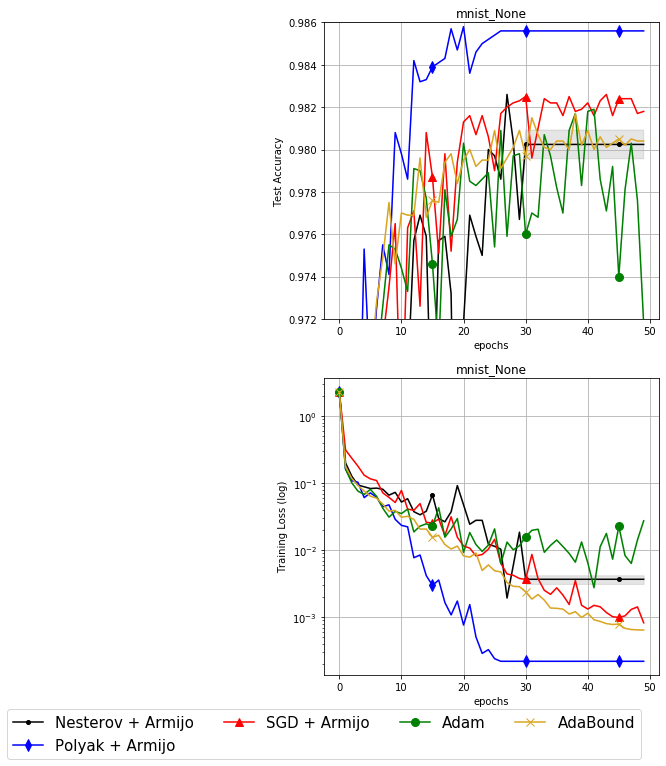

In [5]:
if __name__ == "__main__":
    main()
    